In [33]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import os
import PIL

In [21]:
dir_name = "C:/Users/DDD/Documents/IFPERA/programme_2022/Statistiques appliquées_data_sciences/Data_science_Machine_learning/cat_dog_full"
dataset = keras.utils.image_dataset_from_directory(dir_name, batch_size=64, image_size=(128, 128))

Found 25000 files belonging to 2 classes.


In [31]:
dir_name = pathlib.Path(dir_name)
dir_name

WindowsPath('C:/Users/DDD/Documents/IFPERA/programme_2022/Statistiques appliquées_data_sciences/Data_science_Machine_learning/cat_dog_full')

In [39]:
image_count = len(list(dir_name.glob('*/*.jpg')))
print(image_count)

25000


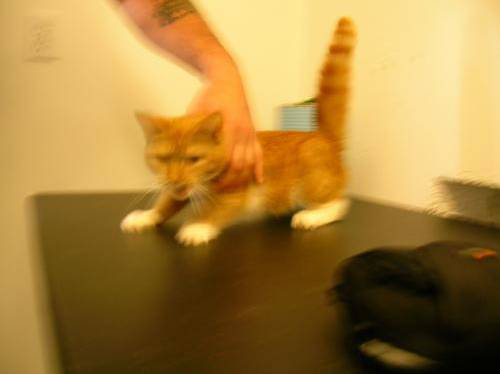

In [34]:
cat = list(dir_name.glob('cat/*'))
PIL.Image.open(str(cat[0]))

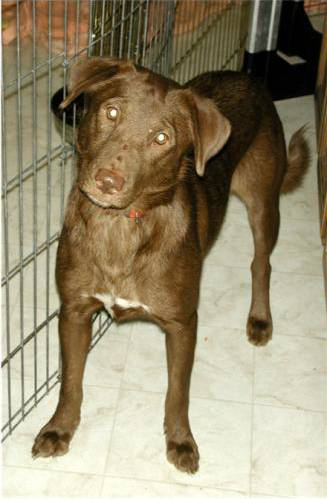

In [37]:
dog = list(dir_name.glob('dog/*'))
PIL.Image.open(str(dog[1]))

In [75]:
batch_size = 32
img_height = 128
img_width = 128
train_ds = tf.keras.utils.image_dataset_from_directory(
  dir_name,
  #color_mode= "grayscale",
  validation_split=0.2,
  subset="training",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dir_name,
  #color_mode= "grayscale",
  validation_split=0.2,
  subset="validation",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [76]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


In [77]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


In [78]:
for data, labels in train_ds.take(1):
    print(data.shape)  # (32, 128, 128, 1)
    print(data.dtype)  # float32
    print(labels.shape)  # (32,)
    print(labels.dtype)

(32, 128, 128, 3)
<dtype: 'float32'>
(32,)
<dtype: 'int32'>


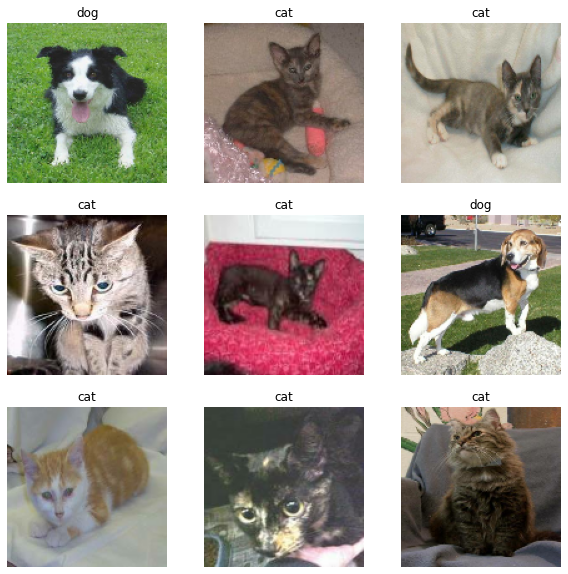

In [79]:
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configurer l'ensemble de données pour les performances
Assurons-nous d'utiliser la prélecture tamponnée afin que vous puissiez récupérer des données à partir du disque sans que les E/S ne deviennent bloquantes. Voici deux méthodes importantes que vous devez utiliser lors du chargement des données :

Dataset.cache conserve les images en mémoire après leur chargement hors disque au cours de la première époque. Cela garantira que l'ensemble de données ne devienne pas un goulot d'étranglement lors de la formation de votre modèle. Si votre jeu de données est trop volumineux pour tenir en mémoire, vous pouvez également utiliser cette méthode pour créer un cache sur disque performant.
Dataset.prefetch chevauche le prétraitement des données et l'exécution du modèle pendant la formation.

In [80]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardiser les données 

In [97]:
normalization_layer = layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.021450866 0.9250388


### Créer le modèle 

In [93]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

img_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.2),
     layers.RandomBrightness(factor=0.8, value_range=(0, 1)),
     layers.RandomContrast(factor=0.3),
    ])

def build_model():
    inputs = layers.Input(shape=(128,128, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [94]:
model = build_model() # define your model normally
METRICS = ['accuracy']
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss = 'binary_crossentropy',
    metrics=METRICS
)
    
model.summary()

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_8 (Sequential)      (None, 128, 128, 3)  0           ['input_6[0][0]']                
                                                                                                  
 rescaling_13 (Rescaling)       (None, 128, 128, 3)  0           ['sequential_8[0][0]']           
                                                                                                  
 normalization_3 (Normalization  (None, 128, 128, 3)  7          ['rescaling_13[0][0]']

 block2a_project_bn (BatchNorma  (None, 32, 32, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 32, 32, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 32, 32, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 32, 32, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 16, 16, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 16, 16, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 16, 16, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 8, 8, 480)   1920        ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 8, 8, 480)   0           ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 8, 8, 672)    0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 8, 8, 112)    75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 8, 8, 112)   448         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 8, 8, 112)    0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 4, 4, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 4, 4, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 4, 4, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 4, 4, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 4, 4, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 4, 4, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 4, 4, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 4, 4, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

In [99]:
epochs=10
history = model.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)

Epoch 1/10


Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter

625/625 [==============================] - 955s 1s/step - loss: 0.7133 - accuracy: 0.5056 - val_loss: 0.6908 - val_accuracy: 0.5196
Epoch 2/10
625/625 [==============================] - 692s 1s/step - loss: 0.7115 - accuracy: 0.5012 - val_loss: 0.6870 - val_accuracy: 0.5780
Epoch 3/10
625/625 [==============================] - 521s 833ms/step - loss: 0.7116 - accuracy: 0.5068 - val_loss: 0.6866 - val_accuracy: 0.5446
Epoch 4/10
625/625 [==============================] - 488s 781ms/step - loss: 0.7080 - accuracy: 0.5102 - val_loss: 0.6869 - val_accuracy: 0.5196
Epoch 5/10
236/625 [==========>...................] - ETA: 3:12 - loss: 0.7060 - accuracy: 0.5050


KeyboardInterrupt



In [19]:
import glob
dog_cat = glob.glob('C:/Users/DDD/Documents/IFPERA/Cours_Machine_Learning/train_final_dog_cat/**/*.jpg', 
                   recursive = True)
dog_cat[5]

'C:/Users/DDD/Documents/IFPERA/Cours_Machine_Learning/train_final_dog_cat\\cat.1001.jpg'

In [4]:
# Get label
def get_label(directory):
    label_id = tf.strings.split(tf.strings.split(directory, sep = '\\')[1], sep = '.')[0]
    return label_id =="cat"  # Will return True for cat and False for dog

In [29]:
IMAGE_SIZE = [224,224]
channels =3

def get_image(path):
    image_bytes = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image_bytes,channels=channels)
    image= tf.image.resize(image,IMAGE_SIZE)
    return image

In [31]:
get_image(path='C:/Users/DDD/Documents/IFPERA/Cours_Machine_Learning/train_final_dog_cat\\cat.1001.jpg').shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TensorShape([224, 224, 3])

In [32]:
# Define maping function
def dataset_process(path):
    image=get_image(path)
    label=get_label(path)
    return image,label

In [33]:
from sklearn.model_selection import train_test_split
train_file, val_file = train_test_split(dog_cat, test_size=0.2, random_state=0)
print("Number of images in train set:", len(train_file))
print("Number of images in validation set:", len(val_file))

Number of images in train set: 3200
Number of images in validation set: 800


In [34]:
# Transforming datasets to tensorflow datasets
train_slice = tf.data.Dataset.from_tensor_slices(train_file)
val_slice = tf.data.Dataset.from_tensor_slices(val_file)

# Verification
for f in train_slice.take(1):
    print(f.numpy())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

b'C:/Users/DDD/Documents/IFPERA/Cours_Machine_Learning/train_final_dog_cat\\cat.243.jpg'


In [35]:
# Verify again train and validation count before maping
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_slice).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_slice).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

<IPython.core.display.Javascript object>

Training images count: 3200


<IPython.core.display.Javascript object>

Validating images count: 800


In [36]:
# We then map list of slices to (image, label) pair using our maping function
# train_ds = training dataset after map
# val_ds = validation dataset after map
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_slice.map(dataset_process)

val_ds = val_slice.map(dataset_process)

# Printing for verification
print('Training dataset:', train_ds)
print('Validation dataset:', val_ds)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training dataset: <MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))>
Validation dataset: <MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))>


In [37]:
BATCH_SIZE = 64
def prepare_for_training(ds, cache=True, shuffle_buffer_size=100):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    #ds = ds.map(image_augment)

    # Repeat forever
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [38]:
def prepare_for_validation(ds, cache=True, shuffle_buffer_size=100):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    #ds = ds.map(image_augment)

    # Repeat forever
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [39]:
training_dataset = prepare_for_training(train_ds)
validation_dataset = prepare_for_validation(val_ds)

image_batch, label_batch = next(iter(training_dataset))
training_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>

In [46]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n]/255, cmap= 'bone')
        if label_batch[n]==True:
            plt.title("cat")
        else:
            plt.title("dog")
        plt.axis("off")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

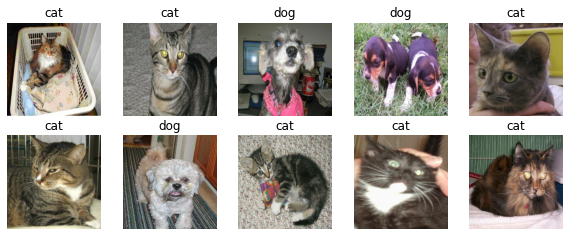

In [47]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

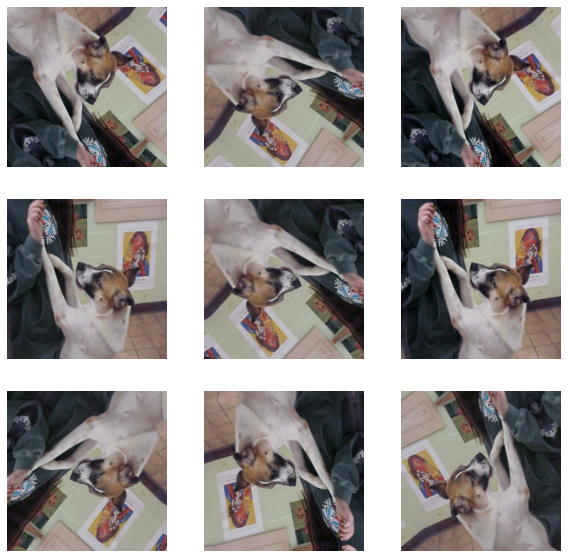

In [60]:
for image, label in training_dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(image)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")

In [102]:
from tensorflow.keras.applications import EfficientNetB0

def build_model():
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [80]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [103]:
model_2 = build_model()

Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [104]:
epochs = 10  # @param {type: "slider", min:8, max:80}
history = model_2.fit(
    training_dataset,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    #class_weight=class_weight,
    #callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
    verbose=2
)

Epoch 1/10


Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.
Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting Bitcast cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.
Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no

50/50 - 316s - loss: 0.0000e+00 - accuracy: 0.6950 - val_loss: 0.0000e+00 - val_accuracy: 0.4844 - 316s/epoch - 6s/step
Epoch 2/10
50/50 - 165s - loss: 0.0000e+00 - accuracy: 0.5022 - val_loss: 0.0000e+00 - val_accuracy: 0.4857 - 165s/epoch - 3s/step
Epoch 3/10
50/50 - 163s - loss: 0.0000e+00 - accuracy: 0.5022 - val_loss: 0.0000e+00 - val_accuracy: 0.4896 - 163s/epoch - 3s/step
Epoch 4/10
50/50 - 166s - loss: 0.0000e+00 - accuracy: 0.5022 - val_loss: 0.0000e+00 - val_accuracy: 0.4922 - 166s/epoch - 3s/step
Epoch 5/10
50/50 - 165s - loss: 0.0000e+00 - accuracy: 0.5022 - val_loss: 0.0000e+00 - val_accuracy: 0.4844 - 165s/epoch - 3s/step
Epoch 6/10
50/50 - 161s - loss: 0.0000e+00 - accuracy: 0.5022 - val_loss: 0.0000e+00 - val_accuracy: 0.4935 - 161s/epoch - 3s/step
Epoch 7/10
50/50 - 169s - loss: 0.0000e+00 - accuracy: 0.5022 - val_loss: 0.0000e+00 - val_accuracy: 0.4948 - 169s/epoch - 3s/step
Epoch 8/10
50/50 - 178s - loss: 0.0000e+00 - accuracy: 0.5022 - val_loss: 0.0000e+00 - val_acc

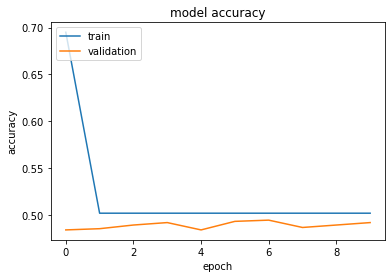

In [106]:
plot_hist(history)